In [39]:
pip install python-box mediapipe gdown

Note: you may need to restart the kernel to use updated packages.


In [40]:
!gdown --id 1p4Ddm9_Cumr51jjAxJ1FY4O_0b8H_jlk
!gdown --id  1hIL8qXT6AfcycSG2UqtsmGQY89SYy850
!gdown --id 15ne89XXtiNp6U9GLmflBJ4DNNeu3NRWK
!gdown --id 1xVKjBOpxVXI9jaxK9GBOFS0VVEAGqRIJ
!gdown --id 1l0eotEZiogvpSyGdroqHus_U77aS2CFU

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1p4Ddm9_Cumr51jjAxJ1FY4O_0b8H_jlk
From (redirected): https://drive.google.com/uc?id=1p4Ddm9_Cumr51jjAxJ1FY4O_0b8H_jlk&confirm=t&uuid=d04a650f-2ee7-45c9-bc5b-9f345ffeda98
To: /kaggle/working/dummy_model.pt
100%|██████████████████████████████████████| 84.9M/84.9M [00:03<00:00, 26.1MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hIL8qXT6AfcycSG2UqtsmGQY89SYy850
To: /kaggle/working/WIN_20230518_16_57_06_Pro.jpg
100%|██████████████████████████████████████| 80.5k/80.5k [00:00<00:00, 90.3MB/s]
/o

In [41]:
# Импортируем библиотеки 
import pprint
import ast
import random
import time
import json
import os
import cv2

import torch
import timm
import torch.nn as nn
import matplotlib.pyplot as plt
import mediapipe as mp
import pandas as pd
import numpy as np
import albumentations as A
from  albumentations.pytorch.transforms import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from box import Box
from tqdm import tqdm

In [42]:
df = pd.read_csv('/kaggle/input/freihand-32000-first/data_new.csv')

xy_points_list = []
for i, row in df.iterrows():
    cleaned_str = [int(i) for i in row['xy_points'].replace('\n', ',').replace('[', ' ').replace(']', ' ').replace(',', ' ').split()]
    uv = [cleaned_str[i:i+2] for i in range(0, len(cleaned_str), 2)]
    xy_points_list.append(uv)

    
df['xy'] = xy_points_list

In [43]:
# Cоздадим конфиг для обучения модели
config = Box()

config.num_workers = os.cpu_count()
config.batch_size = 64
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.seed = 1771
config.model_name = 'tf_efficientnetv2_s_in21k'
config.num_features = 42
config.optimizer_lr = 0.0001
config.epochs = 55
config.test_size = 0.4

In [44]:
# Загружаем нашу модель 
model = torch.load("/kaggle/working/dummy_model.pt", map_location="cpu")
model.eval()
print('Model is loaded')

Model is loaded


In [45]:
# Фиксируем сид для воспроизведения эксперимента в дальнейшем 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

    print(f'Set seed: {seed}')
    
set_seed(seed=config.seed)

Set seed: 1771


In [46]:
# Напишем датаcэт для наших данных 
class HandDatasetTest(Dataset):
    def __init__(self, df, size):
        self.df = df
        self.size = size
        self.transform = A.Compose([
        A.Resize(width=size, height=size, p=1.0),
        A.Normalize(p=1),
        ToTensorV2()],
        keypoint_params=A.KeypointParams(format='xy'))

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image_path, json_path = row['path_to_img'], row['xy']
        image = cv2.imread(image_path)
        
        
        hand_pts = row['xy']
        transformed = self.transform(image=image, keypoints=hand_pts)
        transformed_image = transformed['image']
        transformed_hand_pts = transformed['keypoints']
        
        # Удаляю все точки, которые вышли за рамки нашего кропа. 
        for el in range(len(transformed_hand_pts)):
            if min(transformed_hand_pts[el]) < 0 or max(transformed_hand_pts[el]) >= self.size: 
                transformed_hand_pts[el] = [0., 0.]
            else:
                transformed_hand_pts[el] = [transformed_hand_pts[el][0] / self.size, transformed_hand_pts[el][1] / self.size]
                 
             
        target = torch.tensor([item for sublist in transformed_hand_pts for item in sublist])
        
        

        return (transformed_image.float(), target, image_path)
        

In [47]:
# Создадим из наших данных датасэт, на котором будем сравнивать метрики
train_df, val_df = train_test_split(df, 
                                    test_size=config.test_size,
                                    random_state=config.seed)

dataset_test = HandDatasetTest(val_df.reset_index(), 224)


In [48]:
r_img_V, target, image_path  = dataset_test[random.randint(0, len(dataset_test))]

In [49]:
# Проведем визуальное сравнение на случайном фото нашей модели и модели от mediapipe

# Предсказание медиопайпа
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_resize = cv2.resize(image_rgb, (224, 224), interpolation = cv2.INTER_AREA)

results = hands.process(image_rgb)
results_xy = []
for hand_landmarks in results.multi_hand_landmarks:
        for landmark in hand_landmarks.landmark:
            results_xy.append(landmark.x)
            results_xy.append(landmark.y)

In [50]:
# Предсказания нашей модели 

pred = model.forward(r_img_V.unsqueeze(0))[0]

In [51]:
# Трансформируем предсказанные значения в коориднаты и визуально посмотрим на результат.
# Правильные координаты с разметки
target_upd = target * 224 // 1
target_upd = target_upd.detach().cpu().numpy()
uv = np.array([target_upd[i:i+2] for i in range(0, len(target_upd), 2)])

# Координаты предсказанные нашей моделью
pred = (pred * 224 // 1).detach().cpu().numpy()
pred_xy = np.array([pred[i:i+2] for i in range(0, len(pred), 2)])

# Медиапайп
results_xy = [i * 224 // 1 for i in results_xy]
results_xy_c = np.array([results_xy[i:i+2] for i in range(0, len(results_xy), 2)])


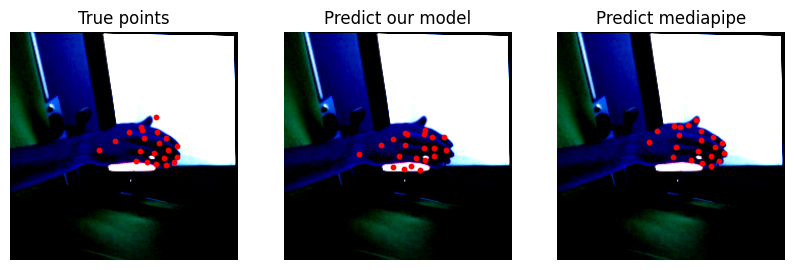

In [52]:
# Отобразим визуально предсказанные координаты 
r_img_V_np = r_img_V.numpy()

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Отображение первой картинки
axs[0].imshow(np.transpose(r_img_V_np, (1, 2, 0)))
axs[0].scatter(uv[:, 0], uv[:, 1], color='red', s=10)
axs[0].axis('off')
axs[0].set_title('True points')
# Отображение второй картинки
axs[1].imshow(np.transpose(r_img_V_np, (1, 2, 0)))
axs[1].scatter(pred_xy[:, 0], pred_xy[:, 1], color='red', s=10)
axs[1].axis('off')
axs[1].set_title('Predict our model')
# Отображение третьей картинки
axs[2].imshow(np.transpose(r_img_V_np, (1, 2, 0)))
axs[2].scatter(results_xy_c[:, 0], results_xy_c[:, 1], color='red', s=10)
axs[2].axis('off')
axs[2].set_title('Predict mediapipe')

# Показать график
plt.show()

In [53]:
# Визуально на случайном изображение медиапайп работает лучше 
# Cравним работу моделей на всех наших данных. 
# Как метрику будем использовать Mean Euclidean Error. 

def mean_euclidean_error(predicted_points, true_points):
    
    predicted_points = np.reshape(predicted_points, (-1, predicted_points.shape[1] // 2, 2))
    true_points = np.reshape(true_points, (-1, true_points.shape[1] // 2, 2))
    
    errors = np.sqrt(np.sum((predicted_points - true_points) ** 2, axis=2))
    mean_error = np.mean(errors) 
    return mean_error
 
# Test
print(f"MEE our model: {mean_euclidean_error(pred_xy, uv):.3f}")
print(f"MEE Mediapipe: {mean_euclidean_error(results_xy_c, uv):.3f}")

MEE our model: 12.303
MEE Mediapipe: 5.428


In [54]:
# Пройдемся по всем изображениям в нашем датафрейме и посчитаем ошибку моделей для сравнения результатов 

# Константы для статистики 
lst_error_pipe = []
lst_error_model = []
our_model_best = 0
pipe_best = 0
pipe_not_detected = 0
for ind in tqdm(range(len(dataset_test))):
    predicts = True
    # Получаем вектор из датасэта
    try:
        r_img_V, target, image_path  = dataset_test[ind]
    except:
        continue
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(image_rgb, (224, 224), interpolation = cv2.INTER_AREA)
    
    # Предсказание medipipe
    results = hands.process(image_rgb)
    results_xy = []
    if results.multi_hand_landmarks is None:
        pipe_not_detected += 1
        continue
        
    for hand_landmarks in results.multi_hand_landmarks:
            for landmark in hand_landmarks.landmark:
                results_xy.append(landmark.x)
                results_xy.append(landmark.y)
                
    # Предсказание модели
    pred = model.forward(r_img_V.unsqueeze(0))[0]
    
    # Трансформируем предсказанные значения в коориднаты 
    # Правильные координаты с разметки
    target_upd = target * 224 // 1
    target_upd = target_upd.detach().cpu().numpy()
    uv = np.array([target_upd[i:i+2] for i in range(0, len(target_upd), 2)])

    # Координаты предсказанные нашей моделью
    pred = (pred * 224 // 1).detach().cpu().numpy()
    pred_xy = np.array([pred[i:i+2] for i in range(0, len(pred), 2)])

    # Медиапайп
    results_xy = [i * 224 // 1 for i in results_xy]
    results_xy_c = np.array([results_xy[i:i+2] for i in range(0, len(results_xy), 2)])
    
    error_model = mean_euclidean_error(pred_xy, uv)
    error_mm = mean_euclidean_error(results_xy_c, uv)
    lst_error_pipe.append(error_mm)
    lst_error_model.append(error_model)
    
    if error_model > error_mm:
        pipe_best += 1
    else:
        our_model_best += 1
        
    

100%|██████████| 13024/13024 [28:37<00:00,  7.58it/s]


In [55]:
mean_error_pipe = np.mean(lst_error_pipe)
mean_error_model = np.mean(lst_error_model)

In [56]:
print(f'MEE our model {mean_error_model}')
print(f'MEE mediapipe model {mean_error_pipe}')
print(f'Our model best {our_model_best}')
print(f'Mediapipe model best {pipe_best}')
print(f'Mediapipe witout detected {pipe_not_detected}')

MEE our model 9.107809066772461
MEE mediapipe model 12.73230297674554
Our model best 6060
Mediapipe model best 4155
Mediapipe witout detected 2806
